In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
#import keras
import matplotlib.pyplot as plt

from subprocess import check_output
print(check_output(["ls", "../Data"]).decode("utf8"))


data_dictionary.txt
macro.csv
macro.xlsx
sample_submission.csv
test.csv
train.csv
train.xlsx



In [2]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

In [3]:
# Загружаем данные. Индексом ставим timestamp.

In [4]:
macro = pd.read_csv('../Data/macro.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
train = pd.read_csv('../Data/train.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
test = pd.read_csv('../Data/test.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)

In [5]:
macro.shape, train.shape, test.shape

((2484, 99), (30471, 291), (7662, 290))

In [6]:
print('macro=',macro.index.min(),macro.index.max())
print('train=',train.index.min(),train.index.max())
print('test =',test.index.min(),test.index.max())

('macro=', Timestamp('2010-01-01 00:00:00'), Timestamp('2016-10-19 00:00:00'))
('train=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))
('test =', Timestamp('2015-07-01 00:00:00'), Timestamp('2016-05-30 00:00:00'))


In [7]:
# Сериализация символьных значений

In [28]:
ntrain, ntest, dictcol = pd.concat([train,macro],axis=1,join='inner'), pd.concat([test,macro],axis=1,join='inner'), {}
ntrain=ntrain.fillna(-1)
ntest =ntest.fillna(-1)
#print ntest.shape, test.shape
for ic,id in zip(test.columns,test.dtypes) :
    if id=='object' or id=='O' :
        ntrain[ic] = ntrain[ic].fillna('0_');
        ntest[ic]  = ntest[ic].fillna('0_');
        temp=ntrain[ic].append(ntest[ic]).unique().tolist(); temp.sort()
        ttemp, i = {}, 0;
        for ii in temp :
            ttemp[ii], i = i, i+1
        dictcol[ic]= ttemp
        ntrain[ic] = ntrain[ic].map(ttemp)
        #ntrain[ic] = ntrain[ic].astype(np.float64)
        ntrain[ic]=ntrain[ic].astype(np.float64,copy=True)
        ntest[ic]  = ntest[ic].map(ttemp)
        #ntest[ic]  = ntest[ic].astype(np.float64)
        ntest[ic]=ntest[ic].astype(np.float64,copy=True)
        #ntest[ic].astypes = np.int64
        #print(ic,id,len(temp),temp,ntest[ic].unique());
        
ntrain=ntrain.fillna(-1)
ntest =ntest.fillna(-1)
del temp, ttemp, dictcol
print train.shape, ntrain.shape, test.shape, ntest.shape
print [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if ntrain.dtypes[i]=='O']
print [ntest.columns[i] for i in range(0,len(ntest.columns)) if ntest.dtypes[i]=='O']

(30471, 291) (30471, 390) (7662, 290) (7662, 389)
['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share']
['modern_education_share', 'old_education_build_share']


In [9]:
# Дополнение train полями usd, eur и расчет дополнительных результативных полей в train (стоимость м2 в usd и eur для жилой и общей площади)

In [31]:
ttrain, ttest = ntrain.copy(), ntest.copy();

ttrain['usd']=ttrain.price_doc/ttrain.usdrub; 
ttrain['eur']=ttrain.price_doc/ttrain.eurrub

ttrain['usdm2full'] = ttrain.usd/(ttrain.full_sq+1.0)
ttrain['usdm2life'] = ttrain.usd/(ttrain.life_sq+1.0)

ttrain['eurm2full'] = ttrain.eur/(ttrain.full_sq+1.0)
ttrain['eurm2life'] = ttrain.eur/(ttrain.life_sq+1.0)

ttrain['full_life'], ttest['full_life'] = (ttrain.full_sq+1)/(ttrain.life_sq+1), (ttest.full_sq+1)/(ttest.life_sq+1)

ttrain['div_eurrub'],  ttest['div_eurrub']  = 1/ttrain.eurrub, 1/ttest.eurrub
ttrain['div_usdrub'],  ttest['div_usdrub']  = 1/ttrain.usdrub, 1/ttest.usdrub
ttrain['div_eurrub2'], ttest['div_eurrub2'] = ttrain.div_eurrub**2, ttest.div_eurrub**2
ttrain['div_usdrub2'], ttest['div_usdrub2'] = ttrain.div_usdrub**2, ttest.div_usdrub**2

ttrain = ttrain[ttrain.usdm2full>0.0]
ttrain = ttrain.dropna()

llist = range(5,15)+range(25,35)+range(55,65)+range(85,95)+range(115,125)+range(145,155)+range(175,185)
xxrain = (pd.concat([macro.usdrub.shift(i) for i in llist], axis=1,keys=['L%s' % i for i in llist])).dropna()

ttrain = pd.concat([ttrain,xxrain],axis=1,join='inner')
ttest  = pd.concat([ttest,xxrain], axis=1,join='inner')

print(train.shape,ttrain.shape,test.shape,ttest.shape,xxrain.shape) #,llist)
ttrain.head()

((30471, 291), (30471, 471), (7662, 290), (7662, 464), (2297, 70))


,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,L175,L176,L177,L178,L179,L180,L181,L182,L183,L184
timestamp,,,,,,,,,,,,,,,,,,,,,
2011-08-20,1,43,27.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,28.8913,28.8913,28.9957,29.1769,29.2807,29.1615,29.1666,29.1666,29.1666,29.2670
2011-08-23,2,34,19.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,28.7238,28.8705,28.8913,28.8913,28.8913,28.9957,29.1769,29.2807,29.1615,29.1666
2011-08-27,3,43,29.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,28.1741,28.1741,28.2145,28.3870,28.7238,28.8705,28.8913,28.8913,28.8913,28.9957
2011-09-01,4,89,50.0,9.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,28.5456,28.3738,28.2550,28.2416,28.1741,28.1741,28.1741,28.2145,28.3870,28.7238
2011-09-05,5,77,77.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,28.5080,28.6150,28.6150,28.6150,28.5456,28.3738,28.2550,28.2416,28.1741,28.1741


In [32]:
# Начинаем строить модель по остаткам train данных

In [32]:
col_res     = ['usdm2full'];
col_notuse  = ['usdm2full','usdm2life','eurm2full','eurm2life','price_doc','id','eur','usd']
col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if ntrain.dtypes[i]=='O']
col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if len(ntrain[ntrain.columns[i]].unique())<=1]

col_use    = [ x for x in ttrain.columns.tolist() if x not in col_notuse];

train_x = ttrain[col_use+col_res]
train_x['r']    = train_x.usdm2full

train_x = train_x.dropna()
train_y = train_x['r']
train_x = train_x[col_use]

test_x  = ttest[col_use]

print train.shape, train_x.shape, test.shape, test_x.shape

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(30471, 291) (30471, 460) (7662, 290) (7662, 460)


In [34]:
#import xgboost as xgb
#gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_x, train_y.ravel())

In [87]:
import xgboost as xgb

def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1.0-preds)
    return grad, hess
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'error', float(sum(labels != (preds > 0.0))) / len(labels)

#param = {'max_depth':2, 'eta':1, 'silent':1}
# train with customized objective
#xgb.cv(param, dtrain, num_round, nfold = 5, seed = 0,
#       obj = logregobj, feval=evalerror)

dtrain = xgb.DMatrix(train_x,label=train_y)

#param = {'silent':1, 'objective':'reg:linear', 'booster':'gblinear',
#         'alpha': 0.0001, 'lambda': 1 }

param = {'silent':1, 'objective':'reg:linear','max_depth':19, 'eta':0.1}
#watchlist  = [(dtest,'eval'), (dtrain,'train')]
watchlist  = [(dtrain,'train')]
num_round = 300 # 300-the best 1000
#history = xgb.cv(param, dtrain, metrics='rmse',num_boost_round=200,nfold=10) #,stratified=True,maximize=True)

#num_round = history['test-rmse-mean'].argmin()
bst = xgb.train(param, dtrain, num_round, watchlist)
train_g = bst.predict(dtrain)

#labels = dtest.get_label()
#print ('error=%f' % ( sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i]) /float(len(preds))))

print np.sqrt(((np.log(np.clip(train_g,0,train_g)+1)-np.log(train_y.values+1))**2).mean())
print(train_g.min(),train_g.max())

[0]	train-rmse:5247.03
[1]	train-rmse:5020.36
[2]	train-rmse:4805.21
[3]	train-rmse:4601.56
[4]	train-rmse:4406.8
[5]	train-rmse:4222.42
[6]	train-rmse:4046.98
[7]	train-rmse:3879.98
[8]	train-rmse:3721.15
[9]	train-rmse:3569.69
[10]	train-rmse:3425.94
[11]	train-rmse:3288.7
[12]	train-rmse:3158.77
[13]	train-rmse:3034.92
[14]	train-rmse:2915.93
[15]	train-rmse:2802.67
[16]	train-rmse:2695.49
[17]	train-rmse:2593.89
[18]	train-rmse:2497
[19]	train-rmse:2404.44
[20]	train-rmse:2315.66
[21]	train-rmse:2231.07
[22]	train-rmse:2150.3
[23]	train-rmse:2073.32
[24]	train-rmse:1998.85
[25]	train-rmse:1928.17
[26]	train-rmse:1860.05
[27]	train-rmse:1794.89
[28]	train-rmse:1732.72
[29]	train-rmse:1673.11
[30]	train-rmse:1616.44
[31]	train-rmse:1561.48
[32]	train-rmse:1508.65
[33]	train-rmse:1458.14
[34]	train-rmse:1409.89
[35]	train-rmse:1363.33
[36]	train-rmse:1319.29
[37]	train-rmse:1276.39
[38]	train-rmse:1235.02
[39]	train-rmse:1195.74
[40]	train-rmse:1158.32
[41]	train-rmse:1121.89
[42]	tra

In [89]:
# Строим результат

In [90]:
dtest = xgb.DMatrix(test_x)
test_p = bst.predict(dtest)

In [91]:
test_r = ttest[['id','usdrub','full_sq']]; test_r['price_doc']=test_p 
test_r.price_doc = test_r.price_doc*test_r.full_sq*test_r.usdrub;
test_r.head()

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,id,usdrub,full_sq,price_doc
timestamp,,,,
2015-07-01,30474,55.5989,39.0,5.270364e+06
2015-07-01,30475,55.5989,79.2,8.762508e+06
2015-07-01,30476,55.5989,40.5,6.210118e+06
2015-07-01,30477,55.5989,62.8,6.117384e+06
2015-07-01,30478,55.5989,40.0,5.239031e+06


In [93]:
test_r[['id','price_doc']].to_csv('../Result/res4.csv',index=False)

In [36]:
#history[:20]
xgb.__version__
#bst.__dict__

'0.6'

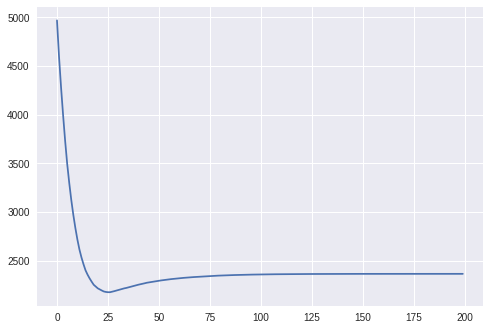

(2176.8698486000003, 25)


In [88]:
plt.plot(history['test-rmse-mean']); plt.show()
print(history['test-rmse-mean'].min(),history['test-rmse-mean'].argmin())

In [40]:
#d = dict(zip(train_x.columns, bst.feature_importances_))
#ss = sorted(d, key=d.get, reverse=True)
fff = bst.get_fscore()
#fff.keys()
fff = pd.DataFrame(fff.values(),index=fff.keys(),columns=['imp'])
ffs = fff.sort_values('imp')
ffs.tail(100)
#ffs.head(40)

,imp
L25,16
cafe_sum_1000_min_price_avg,16
L154,16
prom_part_1000,17
L8,17
L115,17
cafe_count_2000,17
prom_part_1500,17
oil_chemistry_km,18
L176,18


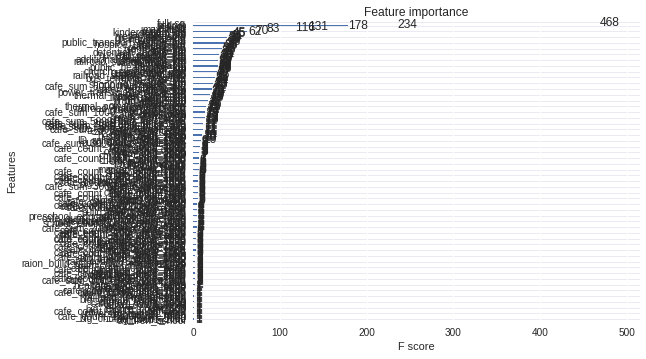

In [61]:
aax = plt.figure(figsize=(16, 16));
xgb.plot_importance(bst); 
#xgb.plot_tree(bst); 
plt.show()